In [1]:
import time
start_time=time.time()

In [2]:
import sys
from pathlib import Path
import json
import numpy as np
from astropy.io import fits
import strucfunc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [3]:
hdulist = fits.open("Obs/GAUS_Ha6562.8_060_Will.fits")

In [4]:
n = None
sb = hdulist[1].data[:n, :n].astype(np.float64)
vv = hdulist[2].data[:n, :n].astype(np.float64)
ss = hdulist[3].data[:n, :n].astype(np.float64)

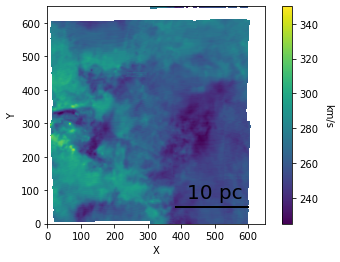

In [5]:
fig, ax = plt.subplots()


dataRV=hdulist[2].data
plt.figure(1)
plt.imshow(dataRV, cmap='viridis')
cbar = plt.colorbar()
plt.clim(225,350)
cbar.set_label('km/s', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')


ax.text(0.9, 0.1, '10 pc',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=20)
    
plt.axhline(y=50, xmin=0.59, xmax=0.925, linewidth=2, color = 'k')


plt.gca().invert_yaxis()

In [6]:
sb

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
vv

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [8]:
RV=pd.DataFrame(vv)

In [9]:
RV=RV.stack().reset_index()

In [10]:
RV[0]

0         271.013497
1         273.394009
2         276.240517
3         273.005903
4         272.423073
             ...    
363054    258.363412
363055    258.422445
363056    259.203970
363057    258.594459
363058    260.029059
Name: 0, Length: 363059, dtype: float64

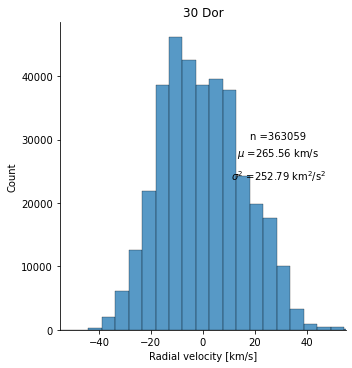

In [11]:
sns.displot(RV[0]-265.56,bins=100)
plt.xlim(-55,55)

plt.text(0.80, 0.90,'n ='+str(RV[0].count()), ha='center', va='center', transform=ax.transAxes, color='k')
plt.text(0.80, 0.82,'$μ$ ='+str(np.round(RV[0].mean(),2))+' km/s', ha='center', va='center', transform=ax.transAxes, color='k')
plt.text(0.80, 0.72,'$σ^{2}$ ='+str(np.round(RV[0].var(),2))+' km$^{2}$/s$^{2}$', ha='center', va='center', transform=ax.transAxes, color='k')

plt.title('30 Dor')

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="15"
plt.xlabel('Radial velocity [km/s]')
plt.savefig('Hist//30Dor.pdf', bbox_inches='tight')


In [12]:
# Replace spurious values in the arrays
m = ~np.isfinite(sb*vv*ss) | (sb < 0.0)

sb[m] = 0.0
vv[m] = np.nanmean(vv)
sb /= sb.max()

In [13]:
sb

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
vv

array([[265.55963257, 265.55963257, 265.55963257, ..., 265.55963257,
        265.55963257, 265.55963257],
       [265.55963257, 265.55963257, 265.55963257, ..., 265.55963257,
        265.55963257, 265.55963257],
       [265.55963257, 265.55963257, 265.55963257, ..., 265.55963257,
        265.55963257, 265.55963257],
       ...,
       [265.55963257, 265.55963257, 265.55963257, ..., 265.55963257,
        265.55963257, 265.55963257],
       [265.55963257, 265.55963257, 265.55963257, ..., 265.55963257,
        265.55963257, 265.55963257],
       [265.55963257, 265.55963257, 265.55963257, ..., 265.55963257,
        265.55963257, 265.55963257]])

In [15]:
ss

array([[0.68, 0.68, 0.68, ..., 0.68, 0.68, 0.68],
       [0.68, 0.68, 0.68, ..., 0.68, 0.68, 0.68],
       [0.68, 0.68, 0.68, ..., 0.68, 0.68, 0.68],
       ...,
       [0.68, 0.68, 0.68, ..., 0.68, 0.68, 0.68],
       [0.68, 0.68, 0.68, ..., 0.68, 0.68, 0.68],
       [0.68, 0.68, 0.68, ..., 0.68, 0.68, 0.68]])

In [16]:
rslt = strucfunc.strucfunc_numba_parallel(vv, wmap=sb, dlogr=0.15)

In [17]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 689.9763913154602 seconds ---


In [18]:
good = (~m) & (sb > 0.001)
rslt["Unweighted mean velocity"] = np.mean(vv[good])
rslt["Unweighted sigma^2"] = np.var(vv[good])
v0w = rslt["Weighted mean velocity"] = np.average(vv, weights=sb)
rslt["Weighted sigma^2"] = np.average((vv - v0w)**2, weights=sb)

In [19]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [20]:
jsonfilename = f"SFdata//30Dor.json"
with open(jsonfilename, "w") as f:
    json.dump(rslt, fp=f, indent=3, cls=MyEncoder)
print(jsonfilename, end="")

SFdata//tarantula-strucfunc.json

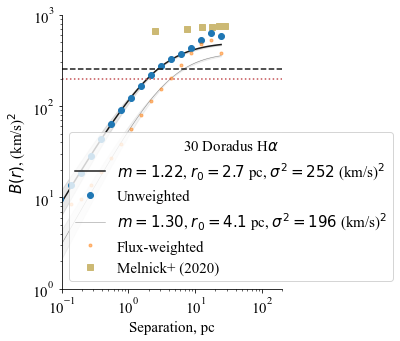

In [21]:
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

def bfunc(r, r0, sig2, m):
    "Theoretical structure function"
    C = 1.0 / (1.0 + (r/r0)**m)
    return 2.0*sig2*(1 - C)

data = json.load(open("SFdata//30Dor.json"))

sns.set_color_codes()
fig, ax = plt.subplots(figsize=(5, 5))

figfile = "tarantula-strucfunc-plot--f.pdf"

pixscale = 0.2 # arcsec
pixscale *= 0.242               # parsec
r = pixscale * 10**np.array(data["log10 r"])
B = np.array(data["Unweighted B(r)"])
sig2 = data["Unweighted sigma^2"]
B_w = np.array(data["Weighted B(r)"])
sig2_w = data["Weighted sigma^2"]

# Plot fit to unweighted strucfunc
rgrid = pixscale * np.logspace(0.0, 2.7)
r0 = np.interp(sig2, B, r)
m = 1.22
flabel = rf"$m = {m:.2f}$, $r_0 = {r0:.1f}$ pc, $\sigma^2 = {sig2:.0f}$ (km/s)$^2$"
ax.fill_between(
    rgrid,
    bfunc(rgrid, r0, sig2, m - 0.1),
    bfunc(rgrid, r0, sig2, m + 0.1),
    color="k", alpha=0.1,
)
ax.plot(rgrid, bfunc(rgrid, r0, sig2, m), color="k", label=flabel)

# Plot points from unweighted strucfunc
ax.plot(r, B, 'o', label="Unweighted")


# Plot fit to weighted strucfunc
r0_w = np.interp(sig2_w, B_w, r)
m_w = 1.30
flabel_w = rf"$m = {m_w:.2f}$, $r_0 = {r0_w:.1f}$ pc, $\sigma^2 = {sig2_w:.0f}$ (km/s)$^2$"
ax.fill_between(
    rgrid,
    bfunc(rgrid, r0_w, sig2_w, m_w - 0.1),
    bfunc(rgrid, r0_w, sig2_w, m_w + 0.1),
    color="k", alpha=0.05,
)
ax.plot(rgrid, bfunc(rgrid, r0_w, sig2_w, m_w), lw=0.5, color="k", alpha=0.5, label=flabel_w)

# Plot points from weighted strucfunc
ax.plot(r, B_w, 'o', ms=3, alpha=0.5, label="Flux-weighted")


melnick_r = np.array([2.5, 7.5, 12.5, 17.5, 22.5, 27.5])
melnick_B = np.array([2.0, 2.1, 2.2, 2.2, 2.25, 2.25]) * 18.2**2
ax.plot(melnick_r, melnick_B, 's', label="Melnick+ (2020)", color="y", zorder=-10)


ax.axhline(sig2, color="k", ls="--")
ax.axhline(sig2_w, color="r", ls=":")
ax.legend(title=r"30 Doradus H$\alpha$")
ax.set(
    xscale = "log",
    yscale = "log",
    ylim  = [1, 1000],
    xlim  = [0.1, 200],
    xlabel = "Separation, pc",
    ylabel = r"$B(r)$, (km/s)$^2$",
)
fig.tight_layout()
sns.despine()
#fig.savefig(figfile)
#fig.savefig(figfile.replace(".pdf", ".jpg"))

In [22]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 691.0607714653015 seconds ---
